In [36]:
from pycocotools.coco import COCO

annotation_file = './HRSID_JPG/HRSID_JPG/annotations/train_test2017.json'
coco = COCO(annotation_file)
coco.anns

loading annotations into memory...
Done (t=0.50s)
creating index...
index created!


{0: {'id': 0,
  'image_id': 0,
  'category_id': 1,
  'segmentation': [[254.0,
    79.0,
    253.0,
    80.0,
    252.0,
    80.0,
    251.0,
    80.0,
    250.0,
    80.0,
    249.0,
    80.0,
    248.0,
    80.0,
    247.0,
    80.0,
    246.0,
    80.0,
    245.0,
    80.0,
    244.0,
    80.0,
    243.0,
    80.0,
    242.0,
    80.0,
    241.0,
    80.0,
    240.0,
    80.0,
    239.0,
    80.0,
    238.0,
    80.0,
    238.0,
    81.0,
    237.0,
    82.0,
    238.0,
    82.0,
    239.0,
    83.0,
    240.0,
    83.0,
    241.0,
    83.0,
    242.0,
    84.0,
    243.0,
    84.0,
    244.0,
    84.0,
    245.0,
    85.0,
    246.0,
    86.0,
    247.0,
    86.0,
    248.0,
    86.0,
    249.0,
    86.0,
    250.0,
    86.0,
    251.0,
    86.0,
    252.0,
    86.0,
    253.0,
    86.0,
    254.0,
    86.0,
    255.0,
    85.0,
    256.0,
    85.0,
    257.0,
    85.0,
    258.0,
    85.0,
    259.0,
    85.0,
    260.0,
    85.0,
    261.0,
    85.0,
    262.0,
    85.0,
    263.0

In [37]:
catIDs = coco.getCatIds()
cats = coco.loadCats(catIDs)

nms=[cat['name'] for cat in cats]
print(len(nms),'COCO categories: \n{}\n'.format(' '.join(nms)))


1 COCO categories: 
ship



In [38]:
filterClasses = ['ship']
catIds = coco.getCatIds(catNms=filterClasses)
imgIds = coco.getImgIds(catIds=catIds)

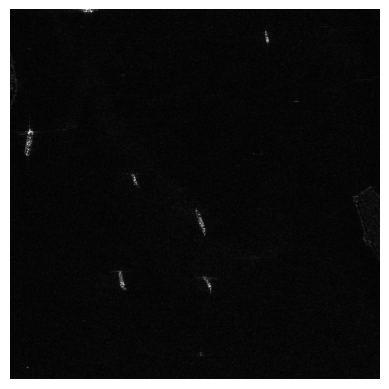

In [39]:
import numpy as np
import skimage.io as io
import matplotlib.pyplot as plt

dataDir='./HRSID_JPG/HRSID_JPG/JPEGImages'
img = coco.loadImgs(imgIds[np.random.randint(0,len(imgIds))])[0]
I = io.imread('{}/{}'.format(dataDir,img['file_name']))/255.0
# Or use url to load image
# I = io.imread(img['coco_url'])
plt.axis('off')
plt.imshow(I)
plt.show()

In [40]:
import random
def filterDataset(folder,file, classes=None):    
    # initialize COCO api for instance annotations
    annFile = '{}/{}'.format(folder, file)
    coco = COCO(annFile)
    
    images = []
    if classes!=None:
        # iterate for each individual class in the list
        for className in classes:
            # get all images containing given categories
            catIds = coco.getCatIds(catNms=className)
            imgIds = coco.getImgIds(catIds=catIds)
            images += coco.loadImgs(imgIds)
    
    else:
        imgIds = coco.getImgIds()
        images = coco.loadImgs(imgIds)
    
    # Now, filter out the repeated images
    unique_images = []
    for i in range(len(images)):
        if images[i] not in unique_images:
            unique_images.append(images[i])
            
    random.shuffle(unique_images)
    dataset_size = len(unique_images)
    
    return unique_images, dataset_size, coco

In [41]:
import cv2
import torch

def getClassName(classID, cats):
    for i in range(len(cats)):
        if cats[i]['id']==classID:
            return cats[i]['name']
    return None

def getImage(imageObj, img_folder, input_image_size):
    # Read and normalize an image
    train_img = io.imread(img_folder + '/' + imageObj['file_name'])/255.0
    # Resize
    train_img = cv2.resize(train_img, input_image_size)
    if (len(train_img.shape)==3 and train_img.shape[2]==3): # If it is a RGB 3 channel image
        return train_img
    
def getBinaryMask(imageObj, coco, catIds, input_image_size):
    annIds = coco.getAnnIds(imageObj['id'], catIds=catIds, iscrowd=None)
    anns = coco.loadAnns(annIds)
    train_mask = np.zeros(input_image_size)
    for a in range(len(anns)):
        new_mask = cv2.resize(coco.annToMask(anns[a]), input_image_size)
        
        #Threshold because resizing may cause extraneous values
        new_mask[new_mask >= 0.5] = 1
        new_mask[new_mask < 0.5] = 0

        train_mask = np.maximum(new_mask, train_mask)

    # Add extra dimension for parity with train_img size [X * X * 3]
    train_mask = train_mask.reshape(input_image_size[0], input_image_size[1], 1)
    return train_mask


class DatasetSegmCoco:
    def __init__(self,images, classes, coco, folder, 
                      input_image_size=(224,224)):
    
        self.img_folder = '{}'.format(folder)
        self.dataset_size = len(images)
        self.catIds = coco.getCatIds(catNms=classes)
        self.input_image_size = input_image_size
        self.coco = coco



    def __getitem__(self, i):
        if(i >= self.dataset_size):
            i = self.dataset_size - 1
        imageObj = images[i]
        
        # read data
        image = getImage(imageObj, self.img_folder, self.input_image_size)

        # extract certain classes from mask (e.g. cars)
        mask = getBinaryMask(imageObj, self.coco, self.catIds, self.input_image_size)
            
        return torch.FloatTensor([image.transpose(2,0,1)]), torch.FloatTensor([mask.transpose(2,0,1)])
        
    def __len__(self):
        #return self.dataset_size
        return 10

In [42]:
folder = './HRSID_JPG/HRSID_JPG/annotations'
classes = ['ship']
ann_train_file = 'train2017.json'

images, dataset_size, coco = filterDataset(folder,ann_train_file, classes)

loading annotations into memory...
Done (t=0.61s)
creating index...
index created!


In [43]:
batch_size = 4
input_image_size = (224,224)
mask_type = 'normal'
img_folder = './HRSID_JPG/HRSID_JPG/JPEGImages'

train_data = DatasetSegmCoco(images, classes, coco, img_folder,
                            input_image_size)

In [44]:
valid_ann_train_file = 'test2017.json'
valid_images, valid_dataset_size, valid_coco = filterDataset(folder,valid_ann_train_file, classes)
valid_data = DatasetSegmCoco(valid_images, classes, valid_coco, img_folder,
                            input_image_size)

loading annotations into memory...
Done (t=0.15s)
creating index...
index created!


In [45]:
#next(iter(train_data))

In [46]:
import matplotlib.gridspec as gridspec

def visualize_data(data):
    img, mask = data[5]
    plt.imshow(img[0,0,:,:])
    plt.show()
    plt.imshow(mask[0,0,:,:])
    plt.show()


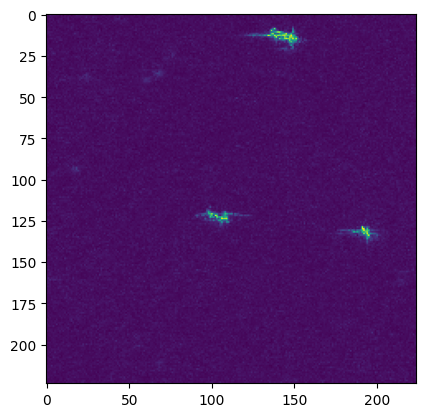

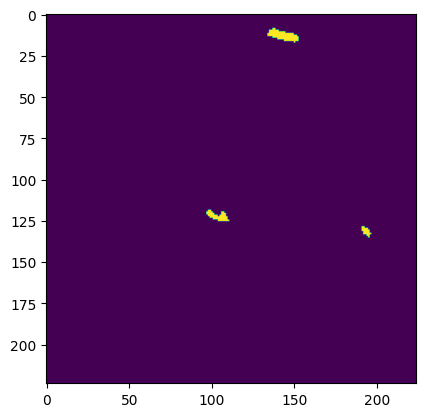

In [47]:
visualize_data(train_data)

In [48]:
import segmentation_models_pytorch as smp


ENCODER = 'resnet18'
ENCODER_WEIGHTS = 'imagenet'
ACTIVATION = 'sigmoid'

model = smp.Unet(ENCODER, encoder_weights=ENCODER_WEIGHTS, classes = 1,activation=ACTIVATION)


In [49]:
from segmentation_models_pytorch.utils.losses import DiceLoss
import torch

loss = DiceLoss()
metrics = [
    smp.utils.metrics.IoU(threshold=0.5),
]

optimizer = torch.optim.Adam([ 
    dict(params=model.parameters(), lr=0.0001),
])

In [50]:
from torch.utils.data import DataLoader

train_loader = DataLoader(train_data, batch_size=1, shuffle=True, persistent_workers=True, num_workers = 12)
valid_loader = DataLoader(valid_data, batch_size=1, shuffle=False, persistent_workers=True, num_workers = 4)


In [51]:
from torch import nn
import pytorch_lightning as pl

class Unet(pl.LightningModule):
    def __init__(self, num_classes, learning_rate):
        super(Unet, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, padding=1)
        self.maxpool1 = nn.MaxPool2d(kernel_size=2)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        self.maxpool2 = nn.MaxPool2d(kernel_size=2)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.transpose_conv3 = nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=2, padding=0, stride=2)
        self.conv2_t = nn.Conv2d(in_channels=64, out_channels=32, kernel_size=3, padding=1)
        self.transpose_conv2 = nn.ConvTranspose2d(in_channels=32, out_channels=16, kernel_size=2, padding=0, stride=2)
        self.conv1_t = nn.Conv2d(in_channels=32, out_channels=16, kernel_size=3, padding=1)
        self.conv_final = nn.Conv2d(in_channels=16, out_channels=num_classes, kernel_size=1)
        self.sigmoid = nn.Sigmoid()
        
        #self.loss = nn.CrossEntropyLoss()
        self.loss = DiceLoss()
        
        self.learning_rate = learning_rate
        
    def forward(self, x):
        
        x1 = F.relu(self.conv1(x))
        x = self.maxpool1(x1)
        x2 = F.relu(self.conv2(x))
        x = self.maxpool2(x2)
        x3 = F.relu(self.conv3(x))
        x2_t = self.transpose_conv3(x3)
        x = torch.cat((x2, x2_t),dim=1)
        x = F.relu(self.conv2_t(x))
        x = self.transpose_conv2(x)
        x = torch.cat((x1, x),dim=1)
        x = F.relu(self.conv1_t(x))
        x = self.conv_final(x)
        
        return self.sigmoid(x)
        
    def training_step(self, batch, batch_idx):
        
        x, y = batch
        output = self(x)
        loss = self.loss(output, y)
        
        #self.log("Loss/Train", loss, on_epoch=True, prog_bar=True, logger=True)
        self.logger.experiment.add_scalar("Loss/Train", loss, self.current_epoch)

        return loss
    
    def validation_step(self, batch, batch_idx):
        
        x, y = batch
        output = self(x)
        output_proj = output.argmax(dim=1)
        jaccard = jaccard_score(y.view(-1), output_proj.view(-1), average='macro')

        #self.log("Jaccard/Valid", jaccard, on_epoch=True, prog_bar=True, logger=True)
        self.logger.experiment.add_scalar("Jaccard/Valid", jaccard, self.current_epoch)

        return jaccard
        
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        

In [52]:
import pytorch_lightning as pl

model = smp.Unet(ENCODER, encoder_weights=ENCODER_WEIGHTS, classes = 1, activation = ACTIVATION)
#unet = Unet(2,0.001)
#trainer = pl.Trainer(max_epochs=1, accelerator="cpu", log_every_n_steps=20)

In [53]:
def train(epoch, model, dataloader_train, dataloader_valid, optimizer, loss_function):
    #training phase
    model.train()
    train_loss = 0
    for i, (imgs, masks) in enumerate(dataloader_train):
        optimizer.zero_grad()
        imgs = imgs.to(DEVICE)
        masks = masks.to(DEVICE)
        #forward pass
        outputs = model(imgs)
        #cal loss and backward
        loss = loss_function(outputs, masks)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_loss /= len(dataloader_train)
    
    #validating phase
    '''
    model.eval()
    valid_loss = 0
    with torch.no_grad():
        for i, (imgs, masks) in enumerate(dataloader_valid):
            imgs = imgs.to(DEVICE)
            masks = masks.to(DEVICE)
            outputs = model(imgs)
            loss = loss_function(outputs, masks)
            valid_loss += loss.item()
    valid_loss /=len(dataloader_valid)
    '''
    print(f'EPOCH: {epoch + 1} - train loss: {train_loss} -  valid_loss: {valid_loss}')
    return train_loss, valid_loss

In [ ]:
epoch = 1
train(epoch,model,train_loader,valid_loader,optimizer, DiceLoss())

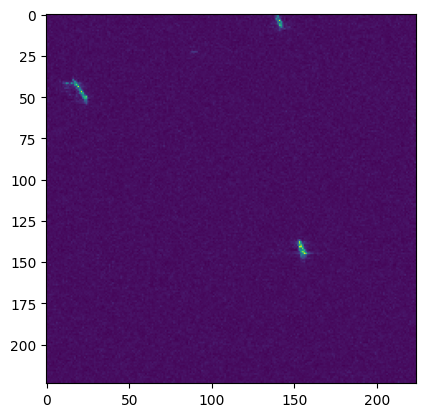

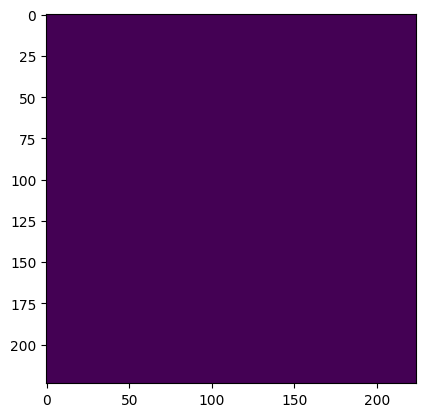

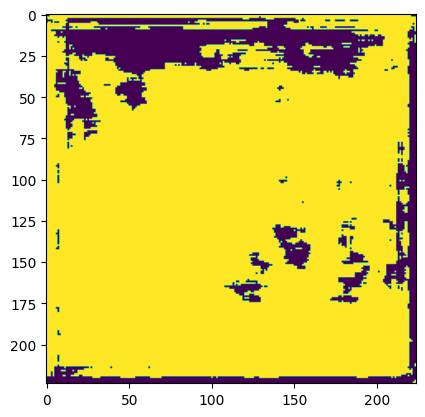

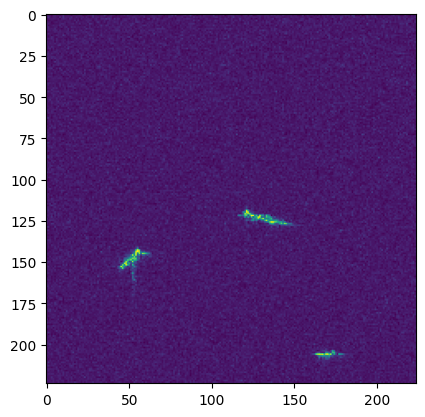

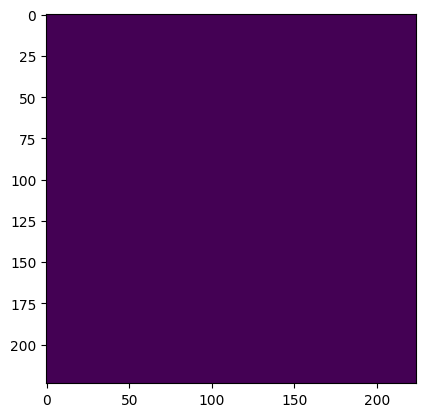

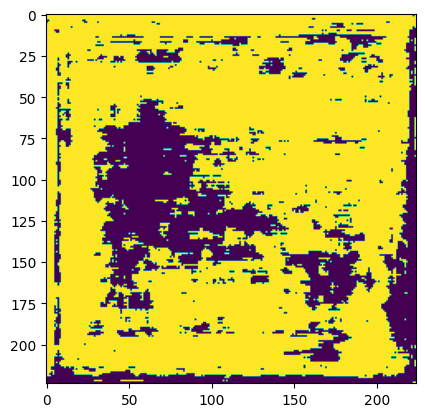

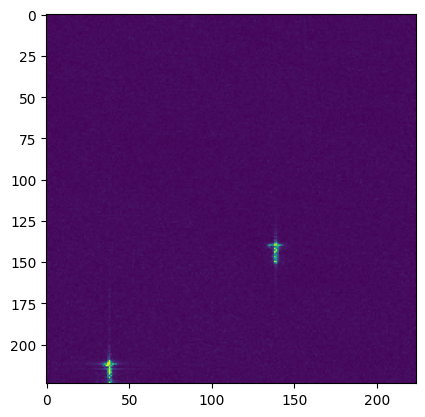

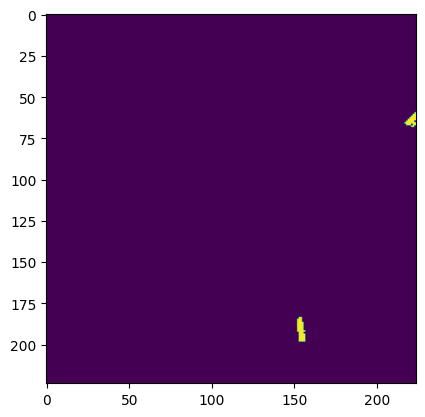

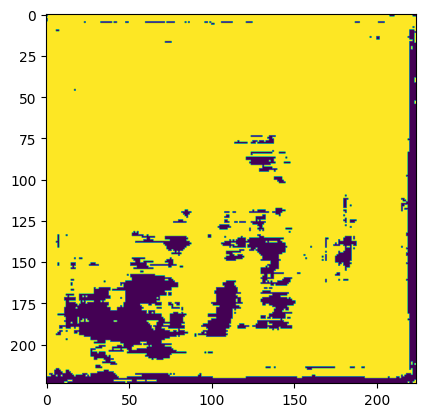

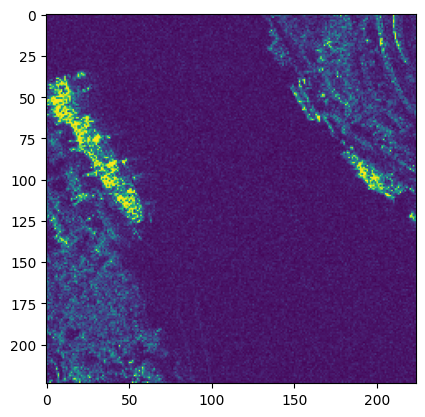

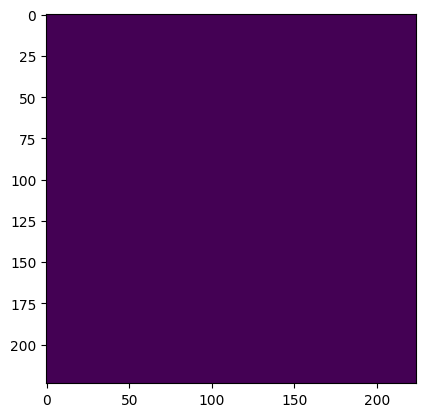

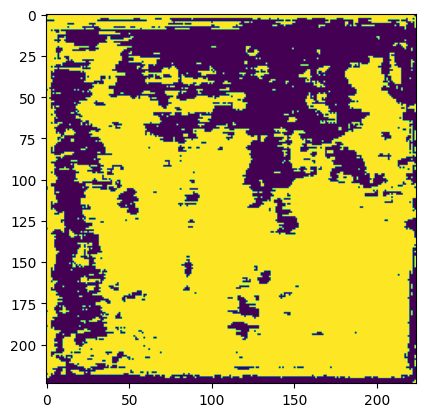

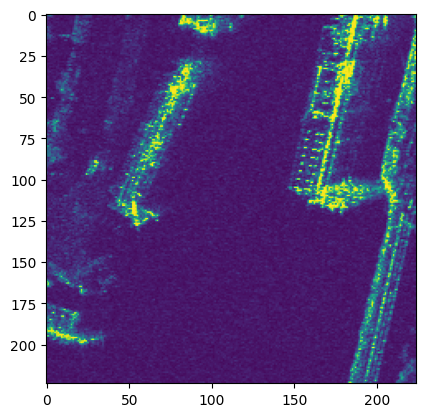

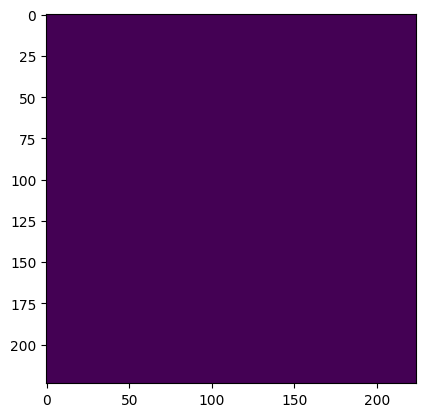

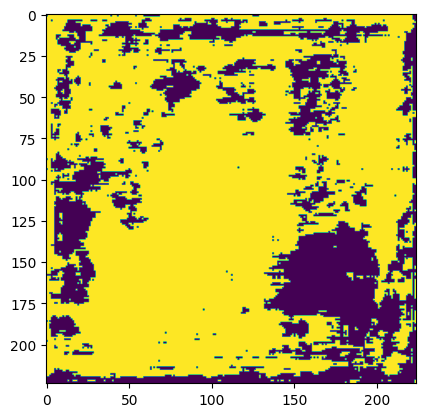

In [32]:
for i in range(5):
    n = np.random.choice(len(valid_data))
    
    image, gt_mask = valid_data[n]

    
    #x_tensor = torch.from_numpy(image).to(DEVICE).unsqueeze(0)
    pr_mask = model.predict(image)
    pr_mask = (pr_mask.squeeze().cpu().numpy().round()).reshape(1,1,224,224)
    
    plt.imshow(image[0,0,:,:])
    plt.show()
    plt.imshow(gt_mask[0,0,:,:])
    plt.show()
    plt.imshow(pr_mask[0,0,:,:])
    plt.show()
